# Hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.metrics import make_scorer
import pickle

In [2]:
data = pd.read_csv('../../datasets/data-stemmed-R.csv')
Y = data['engagement.rate']
X = data.drop(columns=['engagement.rate'])
columns_to_scale= ['quotes','user.tweets','user.following','user.media'] 
scaler = StandardScaler()
X[columns_to_scale]= scaler.fit_transform(X[columns_to_scale]) 

In [3]:
import pickle
try:
    with open('parameters/rt_grid_search.pkl', 'rb') as file:
        rt_grid_search = pickle.load(file)
    with open('parameters/knn_grid_search.pkl', 'rb') as file:
        knn_grid_search = pickle.load(file)
    with open('parameters/rf_grid_search.pkl', 'rb') as file:
        rf_grid_search = pickle.load(file)
    with open('parameters/svr_linear_grid_search.pkl', 'rb') as file:
        svr_linear_grid_search = pickle.load(file)
    with open('parameters/svr_poly_grid_search.pkl', 'rb') as file:
        svr_poly_grid_search = pickle.load(file)
    with open('parameters/svr_rbf_grid_search.pkl', 'rb') as file:
        svr_rbf_grid_search = pickle.load(file)
except Exception as e:
    print(f"Error: {e}")

Error: Can't get attribute 'rmse_scorer' on <module '__main__'>


In [4]:
def rmse_scorer(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return -rmse  # Negate the result for GridSearchCV

**DISCLAIMER:** we want a robust result about the optimal hyperparameters, so we are going to implement a CV. 
Since our future models will be trained in training sets with size $\frac{9}{10}|D|$, we can do hyperparameter tuning with CV on the entire dataset (in order to mantain the same proportion)

# Decision tree

In [ ]:
rt_param_grid = {'min_samples_split': [2, 11, 16, 26,31, 51, 101, 151, 201,501]}
# Create RegressorTree
rt = DecisionTreeRegressor()

# Use GridSearchCV to find the best hyperparameters
rt_grid_search = GridSearchCV(rt, rt_param_grid, cv=10, scoring=make_scorer(rmse_scorer),n_jobs=-1)
rt_grid_search.fit(X, Y)

# Print the best hyperparameters
rt_best_params = rt_grid_search.best_params_

In [ ]:
print(f"Regression tree Best hyperparameters: {rt_best_params}")

In [ ]:
# Save the best parameters to a file using pickle
with open('parameters/rt_grid_search.pkl', 'wb') as file:
    pickle.dump(rt_grid_search, file)

In [ ]:
import os
print(os.path.isfile('parameters/rt_grid_search.pkl'))

In [10]:
import pickle

try:
    with open('parameters/rt_grid_search.pkl', 'rb') as file:
        rt_grid_search = pickle.load(file)
except Exception as e:
    print(f"Error: {e}")

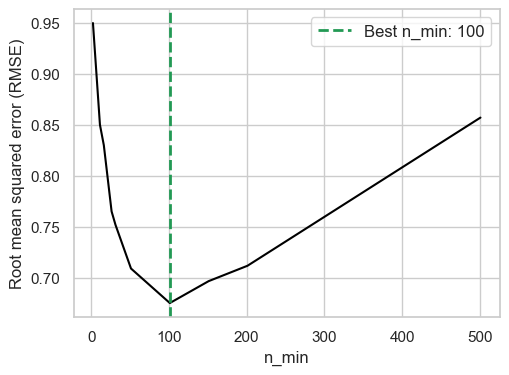

In [23]:
# Get the results in a DataFrame
rt_results = pd.DataFrame(rt_grid_search.cv_results_)
sns.set(style="whitegrid")
# Plot MAE vs n_neighbors using Seaborn
fig=plt.figure(figsize=(5.5, 4))
sns.lineplot(x=rt_results['param_min_samples_split'], y=-rt_results['mean_test_score']-1,color='black')

# Highlight the best parameter
rt_best_param = rt_grid_search.best_params_['min_samples_split']
plt.axvline(x=rt_best_param, color='#229954', linestyle='--', label=f'Best n_min: {rt_best_param-1}',linewidth=2)

# Add labels and title
plt.xlabel('n_min')
plt.ylabel('Root mean squared error (RMSE)')
#plt.title('RMSE vs min_samples_split with GridSearchCV')
plt.legend(loc='upper right',fontsize=12)

# Show the plot
plt.show()
# Save the plot as png
fig.savefig('../../plots/dt_grid_search.png')

# Knn

In [ ]:
# Define the range of neighbors
knn_param_grid = {'n_neighbors': [1, 2, 5, 10, 15, 20, 50, 100]}

# Create KNeighborsRegressor
knn = KNeighborsRegressor()

# Use GridSearchCV to find the best hyperparameters
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=10, scoring=make_scorer(rmse_scorer),n_jobs=-1)
knn_grid_search.fit(X, Y)

# Print the best hyperparameters
knn_best_params = knn_grid_search.best_params_

In [ ]:
print(f"KNN Best hyperparameters: {knn_best_params}")

In [ ]:
# Save the best parameters to a file using pickle
with open('parameters/knn_grid_search.pkl', 'wb') as file:
    pickle.dump(knn_grid_search, file)

In [12]:
with open('parameters/knn_grid_search.pkl', 'rb') as file:
        knn_grid_search = pickle.load(file)

In [13]:
print(knn_grid_search.best_params_)

{'n_neighbors': 20}


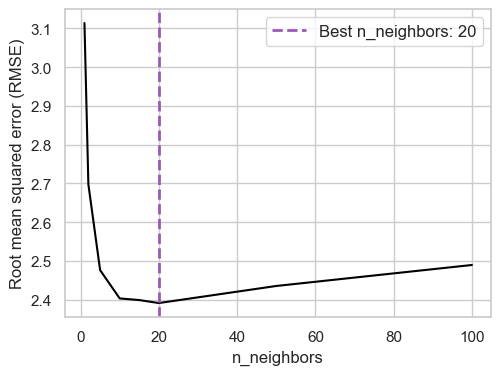

In [29]:
# Get the results in a DataFrame
knn_results = pd.DataFrame(knn_grid_search.cv_results_)

# Plot MAE vs n_neighbors using Seaborn
fig=plt.figure(figsize=(5.5, 4))
sns.lineplot(x=knn_results['param_n_neighbors'], y=-knn_results['mean_test_score'],color='black')

# Highlight the best parameter
knn_best_param = knn_grid_search.best_params_['n_neighbors']
plt.axvline(x=knn_best_param, color='#9B59B6', linestyle='--', label=f'Best n_neighbors: {knn_best_param}',linewidth=2)
plt.xlabel('n_neighbors')
plt.ylabel('Root mean squared error (RMSE)')
#plt.title('RMSE vs n_neighbors with GridSearchCV')
plt.legend(loc='upper right',fontsize=12)

# Show the plot
plt.show()
# Save the plot as png
fig.savefig('../../plots/knn_grid_search.png')

# Random Forest

In [ ]:
n_estimators= [10,15,25,50,75,100, 250, 500]
min_samples_split= [2, 11, 26, 51,76,101] #corrisponde a 1+n_min di medvet
max_features= [math.floor(math.sqrt(X.shape[1])), X.shape[1] // 3]

rf_param_grid = {
    'n_estimators': n_estimators,
    'min_samples_split': min_samples_split,
    'max_features': [X.shape[1] // 3]
}

# Create KNeighborsRegressor
rf = RandomForestRegressor(n_jobs=-1) #n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.

# Use GridSearchCV to find the best hyperparameters
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=10, scoring=make_scorer(rmse_scorer),n_jobs=-1)
rf_grid_search.fit(X, Y)

# Print the best hyperparameters
rf_best_params = rf_grid_search.best_params_

In [ ]:
print(f"Random forest Best hyperparameters: {rf_best_params}")

In [ ]:
# Save the best parameters to a file using pickle
with open('parameters/rf_grid_search.pkl', 'wb') as file:
    pickle.dump(rf_grid_search, file)

In [ ]:
try:
    with open('parameters/rf_grid_search.pkl', 'rb') as file:
        rf_grid_search = pickle.load(file)
except Exception as e:
    print(f"Error: {e}")

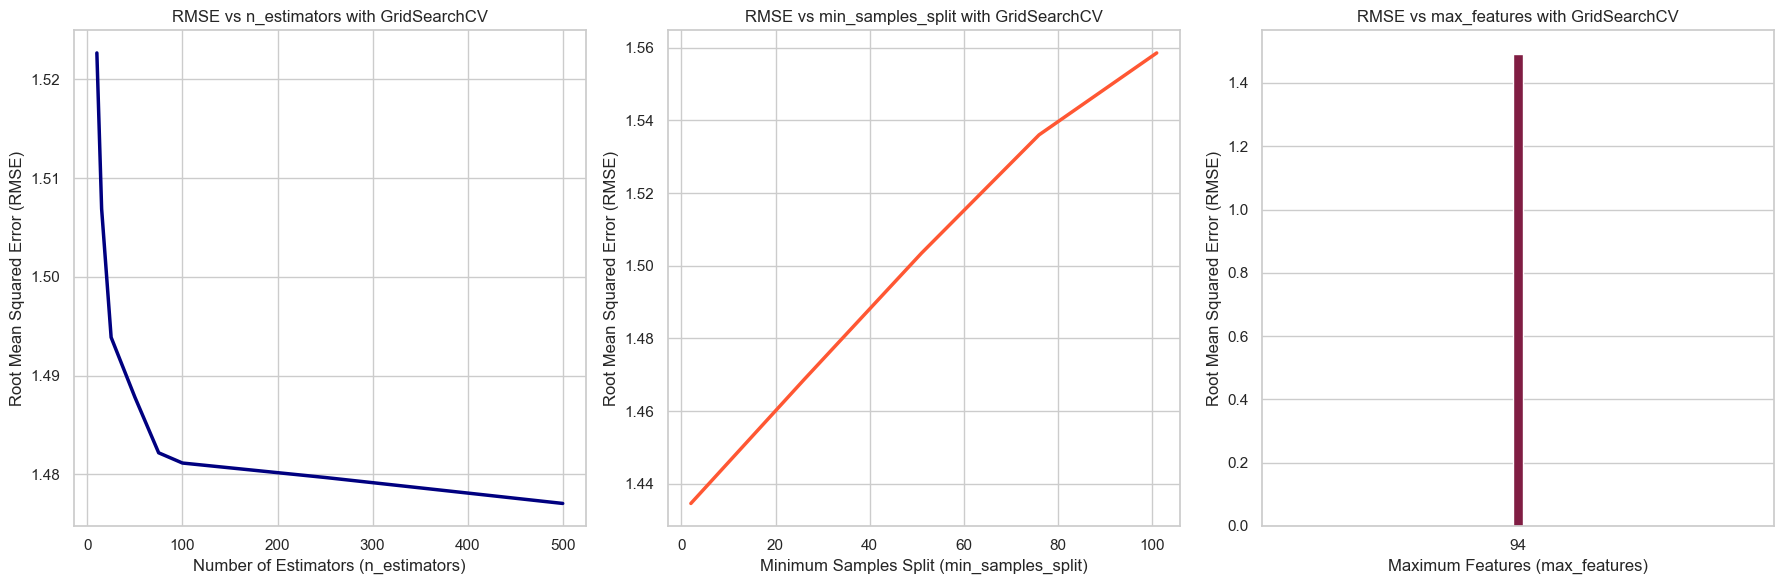

In [22]:
# Get the results in a DataFrame
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

# Create a 1x3 matrix of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot MAE vs n_estimators
sns.lineplot(x='param_n_estimators', y=-rf_results['mean_test_score'],
             data=rf_results, ax=axes[0],errorbar=None,linewidth = 2.5,
             color='navy')
axes[0].set_xlabel('Number of Estimators (n_estimators)')
axes[0].set_ylabel('Root Mean Squared Error (RMSE)')
axes[0].set_title('RMSE vs n_estimators with GridSearchCV')

# Plot MAE vs min_samples_split
sns.lineplot(x='param_min_samples_split', y=-rf_results['mean_test_score'],
             data=rf_results, ax=axes[1],errorbar=None,linewidth = 2.5,
             color='#FF5733')
axes[1].set_xlabel('Minimum Samples Split (min_samples_split)')
axes[1].set_ylabel('Root Mean Squared Error (RMSE)')
axes[1].set_title('RMSE vs min_samples_split with GridSearchCV')

# Plot MAE vs max_features
sns.barplot(x='param_max_features', y=-rf_results['mean_test_score'],
             data=rf_results, ax=axes[2],errorbar=None,
             color='#900C3F',width=0.02)
axes[2].set_xlabel('Maximum Features (max_features)')
axes[2].set_ylabel('Root Mean Squared Error (RMSE)')
axes[2].set_title('RMSE vs max_features with GridSearchCV')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()
# Save the plot as png
fig.savefig('../../plots/rf_grid_search.png')

In [37]:
# Extracting necessary columns
desired_columns = ['param_n_estimators', 'param_min_samples_split', 'param_max_features', 'mean_test_score']
extracted_data = rf_results[desired_columns].copy()

# Renaming columns for clarity
extracted_data.columns = ['n_estimators', 'min_samples_split', 'max_features', 'rmse']

# Converting negative mean test scores to positive MAE
extracted_data['rmse'] = -extracted_data['rmse']

extracted_data=extracted_data[extracted_data['max_features']==X.shape[1] // 3]

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming extracted_data is your DataFrame
sns.set(style="whitegrid")
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(extracted_data['n_estimators'], extracted_data['min_samples_split'], extracted_data['rmse'],
                     c=extracted_data['rmse'], cmap='plasma', s=50)

# Customize the plot
ax.set_xlabel('n_estimators', labelpad=10, fontsize=9, fontweight='bold')
ax.set_ylabel('min_samples_split', labelpad=10, fontsize=9, fontweight='bold')
ax.set_zlabel('RMSE', labelpad=5, fontsize=9, fontweight='bold')
ax.set_title('RMSE vs n_estimators and min_samples_split',
             fontsize=15, fontweight='bold')

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, label='RMSE', shrink=0.3, pad=.12)

# Change the perspective
ax.view_init(elev=30, azim=-40)  # Adjust the elevation and azimuthal angle as needed

# Show the plot
plt.show()
#save as image
fig.savefig('../../plots/rmse_vs_n_estimators_and_min_samples_split_POINTS.png')



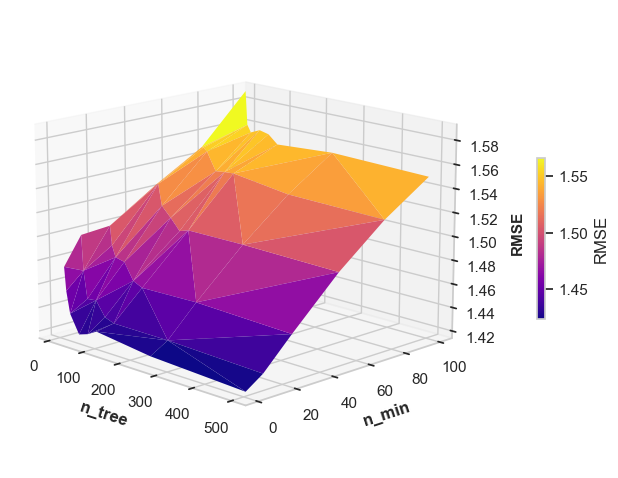

<Figure size 640x480 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns

# Assuming extracted_data is your DataFrame
sns.set(style="whitegrid")
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a continuous surface
surf = ax.plot_trisurf(extracted_data['n_estimators'], extracted_data['min_samples_split']-1,
                       extracted_data['rmse'], cmap='plasma', linewidth=0, antialiased=True)

# Customize the plot
ax.set_xlabel('n_tree', labelpad=5, fontsize=12, fontweight='bold')
ax.set_ylabel('n_min', labelpad=5, fontsize=12, fontweight='bold')
# for z label i want the label text over the values
ax.set_zlabel('RMSE', labelpad=5, fontsize=11, fontweight='bold', rotation=90)
#ax.set_title('RMSE vs n_tree and n_min',fontsize=15, fontweight='bold')

# Add a colorbar
cbar = plt.colorbar(surf, ax=ax, label='RMSE', shrink=0.3, pad=.11)
ax.view_init(elev=15, azim=-45) 
# Show the plot
plt.show()
plt.tight_layout()
#save as image
fig.savefig('../../plots/rmse_vs_n_estimators_and_min_samples_split_SURFACE.png')


Text(0, 0.5, 'n_min')

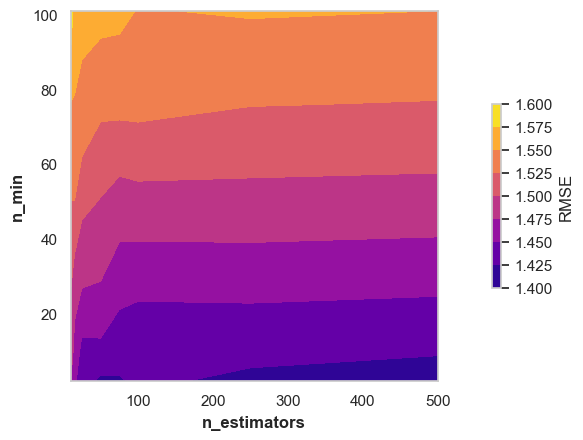

In [98]:
# Create a contour plot
x= extracted_data["n_estimators"].unique()
y=extracted_data["min_samples_split"].unique()
z= extracted_data["rmse"].values.reshape(len(y),len(x))
X, Y = np.meshgrid(x, y)

z= extracted_data["rmse"].values.reshape(len(y),len(x))
fig=plt.contourf(X, Y, z,cmap='plasma')
#cbar with label on the top of rhe bar
cbar = plt.colorbar(fig, label='RMSE', shrink=0.5, pad=.11)
#add x and y labels
plt.xlabel('n_estimators', labelpad=5, fontsize=12, fontweight='bold')
plt.ylabel('n_min', labelpad=5, fontsize=12, fontweight='bold')
# add rmse label in the cbar

# SVR

NB: instead of using the custom RMSE, we use neg_mean_squared_error as scoring ad later we'll compute its sqrt

**Without scaling vars, svr is an asshole!**

In [ ]:
svr_param_grid = {'kernel': ['linear', 'poly', 'rbf']}

svr = SVR()

# Use GridSearchCV to find the best hyperparameters
svr_grid_search = GridSearchCV(svr, svr_param_grid, cv=10, scoring=make_scorer(rmse_scorer),n_jobs=-1)
svr_grid_search.fit(X, Y)

# Print the best hyperparameters
svr_best_params = svr_grid_search.best_params_

In [ ]:
print(f"SVR best kernel: {svr_best_params}")

In [ ]:
# Save the best parameters to a file using pickle
with open('parameters/svr_grid_search.pkl', 'wb') as file:
    pickle.dump(svr_grid_search, file)

In [ ]:
try:
    with open('parameters/svr_grid_search.pkl', 'rb') as file:
        svr_grid_search = pickle.load(file)
except Exception as e:
    print(f"Error: {e}")

In [ ]:
# Get the results in a DataFrame
svr_results = pd.DataFrame(svr_grid_search.cv_results_)

# Plot MAE vs n_neighbors using Seaborn
fig=plt.figure(figsize=(11,5))
sns.barplot(x=svr_results['param_kernel'], y=-svr_results['mean_test_score'],color='navy',
          errorbar=None,width=0.02)
# # Add labels and title
plt.xlabel('Kernel type')
plt.ylabel('Root mean squared error (RMSE)')
plt.title('RMSE vs kernel type with GridSearchCV')
# Show the plot
plt.show()
# Save figure as png
#fig.savefig('../../plots/svr_grid_search.png')

## (1) SVR linear

In [ ]:
svr_linear_param_grid = {'C': [0.001,0.003,0.005,0.01,0.03,0.05]}
svr_linear = SVR(kernel='linear')

# Use GridSearchCV to find the best hyperparameters
svr_linear_grid_search = GridSearchCV(svr_linear, svr_linear_param_grid, cv=10, scoring=make_scorer(rmse_scorer),n_jobs=-1)
svr_linear_grid_search.fit(X, Y)

# Print the best hyperparameters
svr_linear_best_params = svr_linear_grid_search.best_params_

In [ ]:
print(f"SVR linear best parameter: {svr_linear_best_params}")

In [ ]:
# Save the best parameters to a file using pickle
with open('parameters/svr_linear_grid_search.pkl', 'wb') as file:
    pickle.dump(svr_linear_grid_search, file)

In [14]:
try:
    with open('parameters/svr_linear_grid_search.pkl', 'rb') as file:
        svr_linear_grid_search = pickle.load(file)
except Exception as e:
    print(f"Error: {e}")

In [ ]:
# Get the results in a DataFrame
svr_linear_results = pd.DataFrame(svr_linear_grid_search.cv_results_)

# Plot MAE vs n_neighbors using Seaborn
fig=plt.figure(figsize=(5.5, 4))
sns.lineplot(x=svr_linear_results['param_C'], y=-(svr_linear_results['mean_test_score']),color='navy')

# Highlight the best parameter
svr_linear_best_param = svr_linear_grid_search.best_params_['C']
plt.axvline(x=svr_linear_best_param, color='red', linestyle='--', label=f'Best C: {svr_linear_best_param}')

# Add labels and title
plt.xlabel('Regularization parameter (C)')
plt.ylabel('Root Mean Squared Error (RMSE)')
#plt.title('RMSE vs n_neighbors with GridSearchCV')
plt.legend()

# Show the plot
plt.show()
# Save the plot as png
fig.savefig('../../plots/svr_linear_grid_search.png')

## (2) SVR poly

In [ ]:
svr_poly_param_grid = {'C': [0.001,0.005,0.03,0.05,0.1],
                       'degree' : [2, 3, 4, 5, 6, 7]
                       }

svr_poly= SVR(kernel='poly')

# Use GridSearchCV to find the best hyperparameters
svr_poly_grid_search = GridSearchCV(svr_poly, svr_poly_param_grid, cv=10, scoring= make_scorer(rmse_scorer),n_jobs=-1)
svr_poly_grid_search.fit(X, Y)

# Print the best hyperparameters
svr_poly_best_params = svr_poly_grid_search.best_params_
print(f"SVR poly best parameter: {svr_poly_best_params}")

In [ ]:
# Save the best parameters to a file using pickle
with open('parameters/svr_poly_grid_search.pkl', 'wb') as file:
    pickle.dump(svr_poly_grid_search, file)

In [16]:
with open('parameters/svr_poly_grid_search.pkl', 'rb') as file:
    svr_poly_grid_search = pickle.load(file)

In [17]:
svr_poly_grid_search.best_params_

{'C': 0.1, 'degree': 2}

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming svr_poly_results is your DataFrame
sns.set(style="whitegrid")

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


# Create a continuous surface
surf = ax.plot_trisurf(svr_poly_results['param_C'], svr_poly_results['param_degree'], -svr_poly_results['mean_test_score'],
                     cmap='plasma', linewidth=0, antialiased=True)

# Customize the plot
ax.set_xlabel('Regularization parameter (C)', labelpad=10, fontsize=12, fontweight='bold')
ax.set_ylabel('Degree', labelpad=10, fontsize=12, fontweight='bold')
ax.set_zlabel('Root Mean Squared Error (RMSE)', labelpad=5, fontsize=12, fontweight='bold')
ax.set_title('RMSE vs C and Degree', fontsize=15, fontweight='bold')

# Add a colorbar
cbar = plt.colorbar(surf, ax=ax, label='RMSE', shrink=0.6, pad=0.1)
ax.view_init(elev=15, azim=-45) 
# Show the plot
plt.show()

## (3) SVR radial (gaussian)

In [5]:
svr_rbf_param_grid = {'C': [0.1,0.5,1,1.5,5,10,15,25],
                       'gamma' : ['scale','auto']
                       }

svr_rbf= SVR(kernel='rbf')

# Use GridSearchCV to find the best hyperparameters
svr_rbf_grid_search = GridSearchCV(svr_rbf, svr_rbf_param_grid, cv=10, scoring= make_scorer(rmse_scorer),n_jobs=-1)
svr_rbf_grid_search.fit(X, Y)

# Print the best hyperparameters
svr_rbf_best_params = svr_rbf_grid_search.best_params_
print(f"SVR rbf best parameter: {svr_rbf_best_params}")

SVR rbf best parameter: {'C': 5, 'gamma': 'scale'}


In [6]:
# Save the best parameters to a file using pickle
with open('parameters/svr_rbf_grid_search.pkl', 'wb') as file:
    pickle.dump(svr_rbf_grid_search, file)

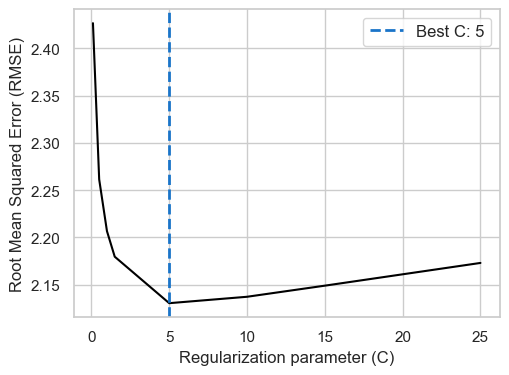

In [58]:
# Get the results in a DataFrame
svr_rbf_results = pd.DataFrame(svr_rbf_grid_search.cv_results_)

sns.set(style="whitegrid")

fig= plt.figure(figsize=(5.5, 4))
sns.lineplot(x=svr_rbf_results['param_C'], y=-svr_rbf_results['mean_test_score'],color='black',errorbar=None)

# Highlight the best parameter
svr_rbf_bestC = svr_rbf_grid_search.best_params_['C']
plt.axvline(x=svr_rbf_bestC, color='#1A74C9', linestyle='--', label=f'Best C: {svr_rbf_bestC}',linewidth=2)

# Add labels and title
plt.xlabel('Regularization parameter (C)')
plt.ylabel('Root Mean Squared Error (RMSE)')
#plt.title('RMSE vs n_neighbors with GridSearchCV')
plt.legend(loc='upper right',fontsize=12)

# Show the plot
plt.show()
# Save the plot as png
fig.savefig('../../plots/svr_rbf_grid_search.png')